<a href="https://colab.research.google.com/github/Rodrigao90/CDR/blob/master/Semana_da_Computa%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importar módulos necessários:

In [1]:
import numpy as np                                                              # Manipulação de arrays              
import librosa as lb                                                            # Processamento de sinais 
import librosa.display as display
from glob import glob                                                           # Encontrar nomes de caminhos com determinado padrão
import matplotlib.pyplot as plt                                                 # Traçar gráficos
import IPython                                                                  # Permitir iteratividade (no caso,  servirá para tocar o áudio .wav) 

from google.colab import drive                                                  # Criar path para o drive

from sklearn.manifold import TSNE                                               # Visualização de dados de alta dimensionalidade
from sklearn.svm import OneClassSVM                                             # SVM de uma classe (Detector de anomalias)
from sklearn.model_selection import train_test_split                            # Devidir conjunto de dado em treino e teste
from sklearn.metrics import accuracy_score, recall_score, precision_score       # Métricas de avaliação
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay            # Para construir matriz de confusão

## 2. Criar path para o drive:

In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 3. Importanto as bases de dados do drive:

### 3.1 Definindo a lista de endereços de áudios normais e anômalos:

In [3]:
# Bases dos endereços dos áudios normais e anômalos
normal_path = '/content/gdrive/MyDrive/Disciplinas 2022.1/Semana da Computação/Dados/Normal/'
anomalous_path = '/content/gdrive/MyDrive/Disciplinas 2022.1/Semana da Computação/Dados/Anômalo/'

# Listas de endereços dos áudios normais e anômalos
normal_files = glob(normal_path + '/*.wav')
anomalous_files = glob(anomalous_path + '/*.wav')

print("Exemplos de endereços")
print("\nNormal: ", normal_files[0])
print("Anômalo: ", anomalous_files[0])

Exemplos de endereços

Normal:  /content/gdrive/MyDrive/Disciplinas 2022.1/Semana da Computação/Dados/Normal/00000001.wav
Anômalo:  /content/gdrive/MyDrive/Disciplinas 2022.1/Semana da Computação/Dados/Anômalo/00000000.wav


### 3.2 Importando e processando os dados: 

Dimensão do array de dados resultante:  (75, 20)

Exemplo de vetor de coeficientes:  [-59.928856   19.593634  -59.928856   10.9813385 -59.928856  -59.928856
 -59.928856  -38.713997  -59.13762   -37.41602   -55.335133  -19.679893
 -46.803383  -49.551414  -56.974804  -42.38691   -19.687971   -7.2177186
  -3.876239  -25.34515  ] 

Dimensão do array de rótulos:  (75,) 



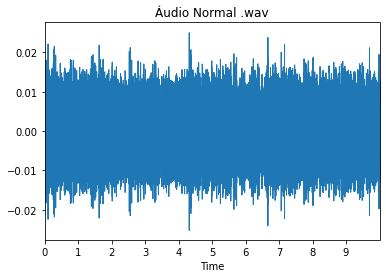

In [4]:
# Lista (array) onde serão armazenados os coeficientes dos áudios normais
normal_data = []
flag = True

for file in normal_files:  
    # Ler arquivo de áudio .wav
    y, sr = lb.load(file, sr=16000)

    # Calcular mfccs médios em dB
    mfcc_coeff = lb.feature.mfcc(y=y, sr=sr)
    mfcc_coeff_db = lb.power_to_db(mfcc_coeff)
    mfcc_coeff_db = np.mean(mfcc_coeff_db, axis=1)   
    normal_data.append(mfcc_coeff_db)

normal_data = np.asarray(normal_data)

print("Dimensão do array de dados resultante: ", normal_data.shape)
print("\nExemplo de vetor de coeficientes: ", normal_data[-1, :], "\n")

# Definindo rótulos dos dados normais
normal_label = np.ones(normal_data.shape[0])
print("Dimensão do array de rótulos: ", normal_label.shape, "\n")

# Plotar exemplo de áudio  normal
display.waveplot(y, sr=sr)
plt.title("Áudio Normal .wav")
IPython.display.Audio(data=y, rate=sr)

Dimensão do array de dados resultante:  (25, 20)

Exemplo de vetor de coeficientes:  [-59.00181     20.697794    10.84501     11.193156   -42.719254
  -1.5788761  -37.10748      2.4346519  -30.154303   -49.721878
 -57.40461    -40.164825   -22.153425   -37.340862   -57.545204
 -53.152187   -28.909912     2.455375    -2.7238743   -0.30696404] 

Dimensão do array de rótulos:  (25,) 



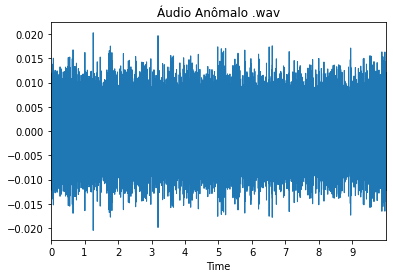

In [5]:
# Lista (array) onde serão armazenados os coeficientes dos áudios anômalos
anomalous_data = []
flag = True

for file in anomalous_files:  
    # Ler arquivo de áudio .wav
    y, sr = lb.load(file, sr=16000)

    # Calcular mfccs médios em dB
    mfcc_coeff = lb.feature.mfcc(y=y, sr=sr)
    mfcc_coeff_db = lb.power_to_db(mfcc_coeff)
    mfcc_coeff_db = np.mean(mfcc_coeff_db, axis=1)   
    anomalous_data.append(mfcc_coeff_db)

anomalous_data = np.asarray(anomalous_data)

print("Dimensão do array de dados resultante: ", anomalous_data.shape)
print("\nExemplo de vetor de coeficientes: ", anomalous_data[-1, :], "\n")

# Definindo rótulos dos dados anômalos
anomalous_label = -np.ones(anomalous_data.shape[0])
print("Dimensão do array de rótulos: ", anomalous_label.shape, "\n")

# Plotar exemplo de áudio anômalo
display.waveplot(y, sr=sr)
plt.title("Áudio Anômalo .wav")
IPython.display.Audio(data=y, rate=sr)

In [6]:
# Normalização dos coeficientes
max_value = np.max(np.abs(normal_data))
min_value = np.min(np.abs(normal_data))

normal_data = (normal_data - min_value)/(max_value - min_value)
anomalous_data = (anomalous_data - min_value)/(max_value - min_value)

### 3.3  Visualizando dissimilaridades entre os dados com TSNE:

In [7]:
# Concatena matrizes de dados normais e anômalos, formando uma só.
X = np.concatenate((normal_data, anomalous_data), axis=0)

# Gera representação dos dados de alta dimensionalidade num espaço bidimensional
X_embedded = TSNE(n_components=2).fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


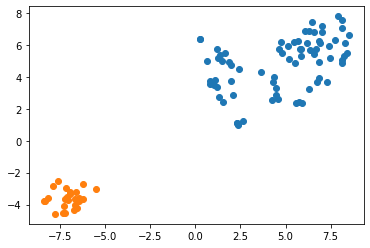

In [8]:
# Plotar a representação dos dados no espaço bidimensional
plt.scatter(X_embedded[:75, 0], X_embedded[:75, 1])
plt.scatter(X_embedded[75:, 0], X_embedded[75:, 1])
plt.show()

## 4. Classificando os dados com o SVM de uma classe (OC-SVM):

In [9]:
# Dividindo os dados normais em treino e teste:

X_normal_train, X_normal_test, y_normal_train, y_normal_test = train_test_split(normal_data, 
                                                                                normal_label,
                                                                                test_size = 0.33)

# Concatenando dados e rótulos que serão utilizados para teste:
X_test = np.concatenate((X_normal_test, anomalous_data), axis = 0)
y_test = np.concatenate((y_normal_test, anomalous_label), axis = 0)

# Dimensionalidade final de cada conjunto de dados:
print("Dim. dados de treino: ", X_normal_train.shape)
print("Dim. dados de teste: ", X_test.shape)
print("Dim. rótulos de treino: ", y_normal_train.shape)
print("Dim. rótulos de teste ", y_test.shape)

Dim. dados de treino:  (50, 20)
Dim. dados de teste:  (50, 20)
Dim. rótulos de treino:  (50,)
Dim. rótulos de teste  (50,)


In [10]:
#  Definindo e treinando o classificador de uma classe
oc_svm = OneClassSVM(nu=0.01).fit(X_normal_train)

In [11]:
# Observando os resultados
pred_y_test = oc_svm.predict(X_test)

print("Resultado esperado: \n", y_test)
print("Resultado do classificador: \n", pred_y_test)

Resultado esperado: 
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
Resultado do classificador: 
 [ 1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1]


Acurácia:  0.98
Precisão:  1.0
Recall:  0.96


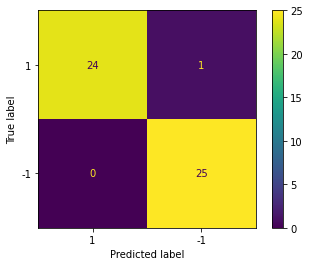

In [12]:
# Avaliando os resultados com métricas de avaliação
print("Acurácia: ", accuracy_score(y_test, pred_y_test))
print("Precisão: ", precision_score(y_test, pred_y_test))
print("Recall: ", recall_score(y_test, pred_y_test))

# Plotar a matriz de confusão
cm = confusion_matrix(y_test, pred_y_test, labels=[1, -1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, -1])
disp.plot()
plt.show()